# Airline Incident Analysis: Model Selection and Methodology

## Exceutive Summary
This notebook documents the methodology and justification for selecting machine learning models.

**Key Finding**: Individual token analysis (TF-IDF) provides the most reliable performance for incident classification, achieving 82% accuracy.

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
print('Environment setup complete.')

Environment setup complete.


In [7]:
# Import functions from processing script
import sys
sys.path.append('./scripts')    # Adjust path based on notebook's location
from data_processing import load_raw_data, feature_engineering, initial_ml_clustering

# Load and process data
print("Loading and processing data...")
df = pd.read_csv(".\data\Airline Occurences.csv")
df_ml, tfidf_features, phrase_features, tfidf_vec, phrase_vec = feature_engineering(df)

print(f"Original dataset: {df.shape}")
print(f"ML dataset: {df_ml.shape}")
print(f"TF-IDF features: {tfidf_features.shape}")
print(f"Phrases features: {phrase_features.shape}")

Loading and processing data...
Original shape: (100028, 4)
Missing values per column:
Report                                0
Part Failure                          0
Occurence Nature condition            0
Occurence Precautionary Procedures    0
dtype: int64
Cleaned shape: (100028, 4)
Processing Report column...
Creating phrase features...
ML dataset shape: (100028, 5)
TF-IDF features shape: (100028, 1000)
Phrase features shape: (100028, 500)
Original dataset: (100028, 4)
ML dataset: (100028, 5)
TF-IDF features: (100028, 1000)
Phrases features: (100028, 500)


In [10]:
def preprocess_text_notebook(text):
    """Clean text for analysis"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean the report textx
df['report_clean'] = df['Report'].apply(preprocess_text_notebook)
print("Text preprocessing complete.")
print(f"Sample cleaned text: {df['report_clean'].iloc[0][:100]}...")

Text preprocessing complete.
Sample cleaned text: mechanical landing gear gnd fail msg after takeoff emergency declared brake overheat caution message...


Part Failure distribution (top 20):
Part Failure
FUSELAGE CRACKED                     1998
ZONE 100 CORRODED                    1926
FUSELAGE CORRODED                    1843
EMERGENCY LIGHTS INOPERATIVE         1272
ZONE 200 CORRODED                    1145
AFT CARGO CORRODED                    946
ZONE 200 - FUSE INOPERATIVE           925
HORIZONTAL STAB CRACKED               794
UNKNOWN UNKNOWN                       707
CABIN INOPERATIVE                     693
EMERGENCY LIGHTS NO TEST              679
EMERGENCY LIGHT INOPERATIVE           646
ZONE 100 - FUSE CORRODED              644
AFT CARGO BAY CORRODED                611
PAX DOOR CORRODED                     580
ZONE 800 - DOORS LOW PRESSURE         527
FWD CARGO CRACKED                     473
ZONE 100 CRACKED                      452
CABIN ODOR                            449
AFT CARGO CRACKED                     447
Name: count, dtype: int64

Filtered dataset: 17757 records
Number of failure types: 20


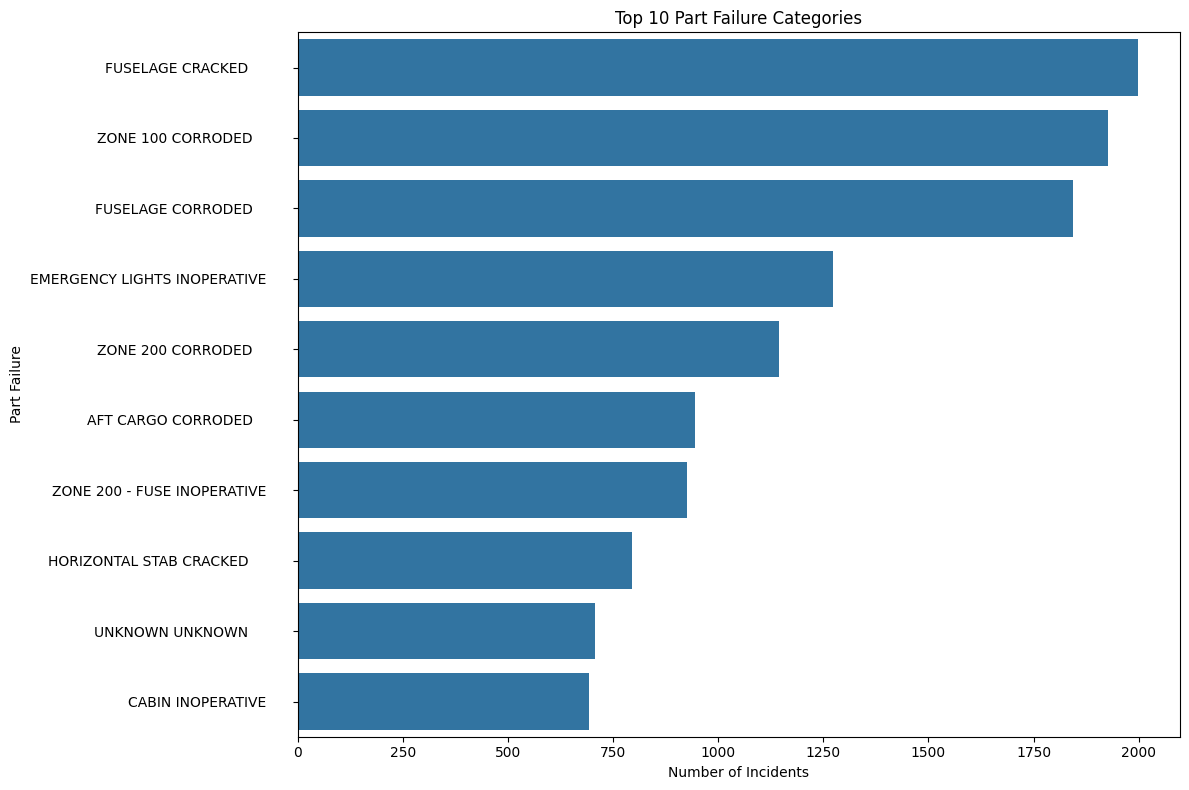

In [11]:
# Analyse target variable distribution
print("Part Failure distribution (top 20):")
failure_counts = df['Part Failure'].value_counts()
print(failure_counts.head(20))

# Filter to top 20 for manageable analysis
top_20_failures = failure_counts.head(20).index
df_filtered = df[df['Part Failure'].isin(top_20_failures)].copy()

print(f"\nFiltered dataset: {len(df_filtered)} records")
print(f"Number of failure types: {df_filtered['Part Failure'].nunique()}")

# Visualise
plt.figure(figsize=(12, 8))
sns.barplot(data=df_filtered['Part Failure'].value_counts().head(10).reset_index(),
            x='count', y='Part Failure')
plt.title('Top 10 Part Failure Categories')
plt.xlabel('Number of Incidents')
plt.tight_layout()
plt.show()

## 2. Model Architecture Comparison

We'll compare four approaches:
1. **TF-IDF Fetaures**: Individual token analysis
2. **Phrase Fetaures**: N-gram analysis (bigrams/trigrams)
3. **Combined Featuers**: TF-IDF + Phrase
4. **Meta-Learning**: Ensemble of all approaches

In [14]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features = 1000,
    stop_words='english',
    ngram_range=(1, 1),    # Invidiual word only
    min_df=2
)

# Fit and transform text data
X_tfidf = tfidf_vectorizer.fit_transform(df_filtered['report_clean'])
y = df_filtered['Part Failure']

print(f"TF-IDF fetaure matrix shape: {X_tfidf.shape}")
print(f"Target variable shape: {y.shape}")

# Train-test-split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest model
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)

# Predict
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)

print(f"\nTF-IDF Model Performance:")
print(classification_report(y_test, y_pred_tfidf))

TF-IDF fetaure matrix shape: (17757, 1000)
Target variable shape: (17757,)

TF-IDF Model Performance:
                                   precision    recall  f1-score   support

   AFT CARGO BAY CORRODED               0.67      0.48      0.56       122
       AFT CARGO CORRODED               0.71      0.60      0.65       189
       AFT CARGO CRACKED                0.74      0.75      0.75        89
           CABIN INOPERATIVE            0.71      0.58      0.63       139
           CABIN ODOR                   0.98      0.99      0.98        90
 EMERGENCY LIGHT INOPERATIVE            0.73      0.63      0.68       129
EMERGENCY LIGHTS INOPERATIVE            0.71      0.82      0.76       255
EMERGENCY LIGHTS NO TEST                0.88      0.80      0.84       136
        FUSELAGE CORRODED               0.74      0.87      0.80       369
        FUSELAGE CRACKED                0.80      0.90      0.85       400
       FWD CARGO CRACKED                0.83      0.51      0.63        

In [20]:
# Create Phrase Vectorizer (bigram/trigram)
phrase_vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(2, 3),    # Bigrams and Trigrams
    min_df=2
)

# Fit and transform
X_phrases = phrase_vectorizer.fit_transform(df_filtered['report_clean'])

print(f"Phrase feature matrix shape: {X_phrases.shape}")

# Train-test-split
X_train_phrases, X_test_phrases, _, _ = train_test_split(
    X_phrases, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
rf_phrases = RandomForestClassifier(n_estimators=100, random_state=42)
rf_phrases.fit(X_train_phrases, y_train)

# Predict
y_pred_phrases = rf_phrases.predict(X_test_phrases)

print(f"\nPhrase Features Model Performance:")
print(classification_report(y_test, y_pred_phrases))

Phrase feature matrix shape: (17757, 500)

Phrase Features Model Performance:
                                   precision    recall  f1-score   support

   AFT CARGO BAY CORRODED               0.65      0.42      0.51       122
       AFT CARGO CORRODED               0.57      0.59      0.58       189
       AFT CARGO CRACKED                0.62      0.73      0.67        89
           CABIN INOPERATIVE            0.58      0.43      0.49       139
           CABIN ODOR                   0.85      0.62      0.72        90
 EMERGENCY LIGHT INOPERATIVE            0.60      0.50      0.55       129
EMERGENCY LIGHTS INOPERATIVE            0.61      0.73      0.66       255
EMERGENCY LIGHTS NO TEST                0.77      0.63      0.69       136
        FUSELAGE CORRODED               0.70      0.69      0.69       369
        FUSELAGE CRACKED                0.72      0.78      0.75       400
       FWD CARGO CRACKED                0.73      0.61      0.67        95
 HORIZONTAL STAB CRAC

In [22]:
# Combine TF-IDF and Phrase features
X_combined = hstack([X_tfidf, X_phrases])

print(f"Combined feature maxtrix shape: {X_combined.shape}")

# Train-test-split
X_train_combined, X_test_combined, _, _ = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_train_combined, y_train)

# Predict
y_pred_combined = rf_combined.predict(X_test_combined)

print("\nCombined Features Model Performance:")
print(classification_report(y_test, y_pred_combined))

Combined feature maxtrix shape: (17757, 1500)

Combined Features Model Performance:
                                   precision    recall  f1-score   support

   AFT CARGO BAY CORRODED               0.64      0.48      0.54       122
       AFT CARGO CORRODED               0.66      0.66      0.66       189
       AFT CARGO CRACKED                0.75      0.84      0.79        89
           CABIN INOPERATIVE            0.72      0.58      0.64       139
           CABIN ODOR                   0.99      0.99      0.99        90
 EMERGENCY LIGHT INOPERATIVE            0.75      0.63      0.68       129
EMERGENCY LIGHTS INOPERATIVE            0.69      0.82      0.75       255
EMERGENCY LIGHTS NO TEST                0.91      0.76      0.83       136
        FUSELAGE CORRODED               0.77      0.84      0.81       369
        FUSELAGE CRACKED                0.83      0.89      0.86       400
       FWD CARGO CRACKED                0.82      0.57      0.67        95
 HORIZONTAL STA

In [24]:
# Get out-of-fold predictions to avoid overfitting
print("Generating cross-validation predictions for meta-learner...")

pred_tfidf = cross_val_predict(rf_tfidf, X_tfidf, y, cv=5, method='predict_proba')
pred_phrases = cross_val_predict(rf_phrases, X_phrases, y, cv=5, method='predict_proba')
pred_combined = cross_val_predict(rf_combined, X_combined, y, cv=5, method='predict_proba')

# Stack predictions as features
meta_features = np.hstack([pred_tfidf, pred_phrases, pred_combined])
print(f"Meta-features shape: {meta_features.shape}")

# Train meta-learner
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(meta_features, y)

# Get meta-learner predictions using cross-val
meta_predictions = cross_val_predict(meta_model, meta_features, y, cv=5)

print("\nMeta-Leaner performance:")
print(classification_report(y, meta_predictions))

Generating cross-validation predictions for meta-learner...
Meta-features shape: (17757, 60)

Meta-Leaner performance:
                                   precision    recall  f1-score   support

   AFT CARGO BAY CORRODED               0.30      0.12      0.17       611
       AFT CARGO CORRODED               0.43      0.55      0.48       946
       AFT CARGO CRACKED                0.69      0.67      0.68       447
           CABIN INOPERATIVE            0.50      0.38      0.43       693
           CABIN ODOR                   0.98      0.98      0.98       449
 EMERGENCY LIGHT INOPERATIVE            0.63      0.50      0.56       646
EMERGENCY LIGHTS INOPERATIVE            0.55      0.62      0.59      1272
EMERGENCY LIGHTS NO TEST                0.78      0.62      0.69       679
        FUSELAGE CORRODED               0.63      0.70      0.66      1843
        FUSELAGE CRACKED                0.76      0.81      0.78      1998
       FWD CARGO CRACKED                0.71      0.51 

## 3. Performance Comparison and Analysis

Model Performance Summary:
              accuracy  f1_weighted
TF-IDF           0.816        0.811
Phrases          0.713        0.708
Combined         0.820        0.817
Meta-Learner     0.693        0.686


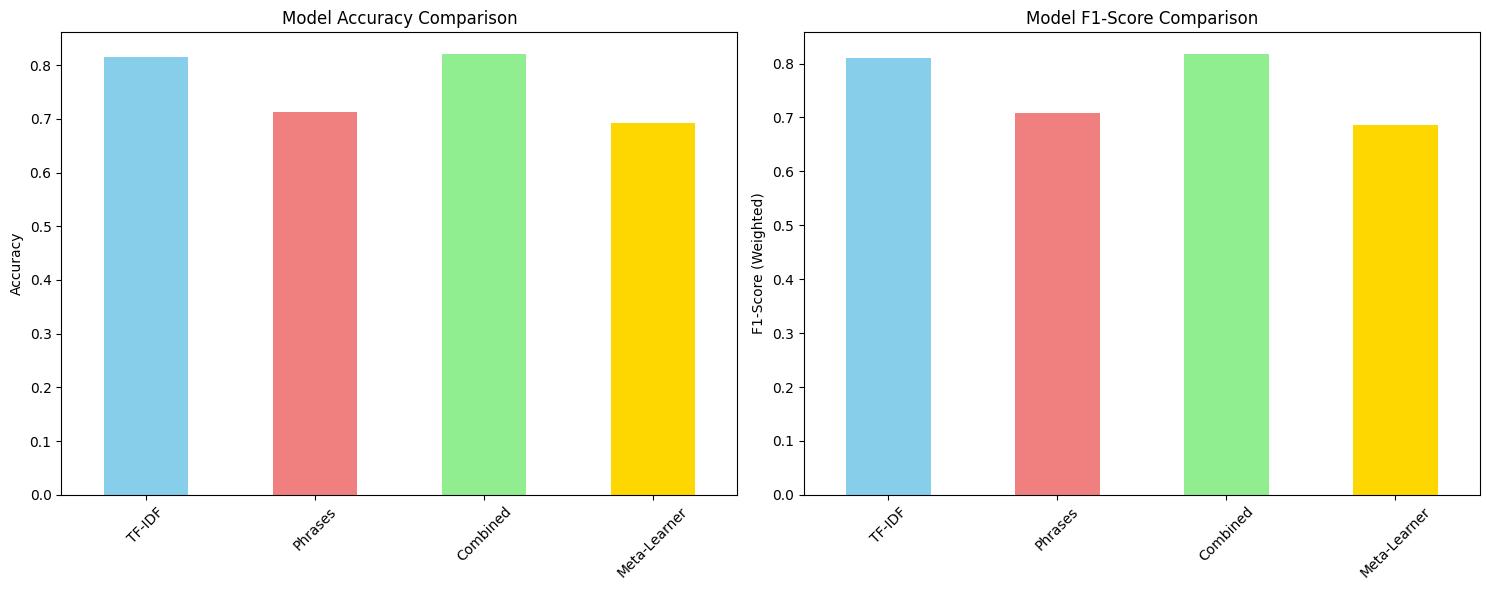

In [29]:
# Calculate summary metrics for each model
models_performance = {
    'TF-IDF': {
        'accuracy': accuracy_score(y_test, y_pred_tfidf),
        'f1_weighted': f1_score(y_test, y_pred_tfidf, average='weighted')
    },
    'Phrases': {
        'accuracy': accuracy_score(y_test, y_pred_phrases),
        'f1_weighted': f1_score(y_test, y_pred_phrases, average='weighted')
    },
    'Combined': {
        'accuracy': accuracy_score(y_test, y_pred_combined),
        'f1_weighted': f1_score(y_test, y_pred_combined, average='weighted')
    },
    'Meta-Learner': {
        'accuracy': accuracy_score(y, meta_predictions),
        'f1_weighted': f1_score(y, meta_predictions, average='weighted')
    }
}

# Create comparison DF
performance_df = pd.DataFrame(models_performance).T
performance_df = performance_df.round(3)

print("Model Performance Summary:")
print(performance_df)

# Visualise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Score comparison
performance_df['accuracy'].plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# F1 Score comparison
performance_df['f1_weighted'].plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax2.set_title('Model F1-Score Comparison')
ax2.set_ylabel('F1-Score (Weighted)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Top 20 Most Important Tokens (TF-IDF Model):
corrosion       : 0.0297
aircraft        : 0.0194
crack           : 0.0167
emergency       : 0.0159
grounded        : 0.0157
corroded        : 0.0154
cracked         : 0.0154
cargo           : 0.0140
aft             : 0.0135
33              : 0.0120
battery         : 0.0115
51              : 0.0114
srm             : 0.0113
replaced        : 0.0113
02              : 0.0110
amm             : 0.0108
yes             : 0.0102
01              : 0.0101
horizontal      : 0.0095
base            : 0.0091


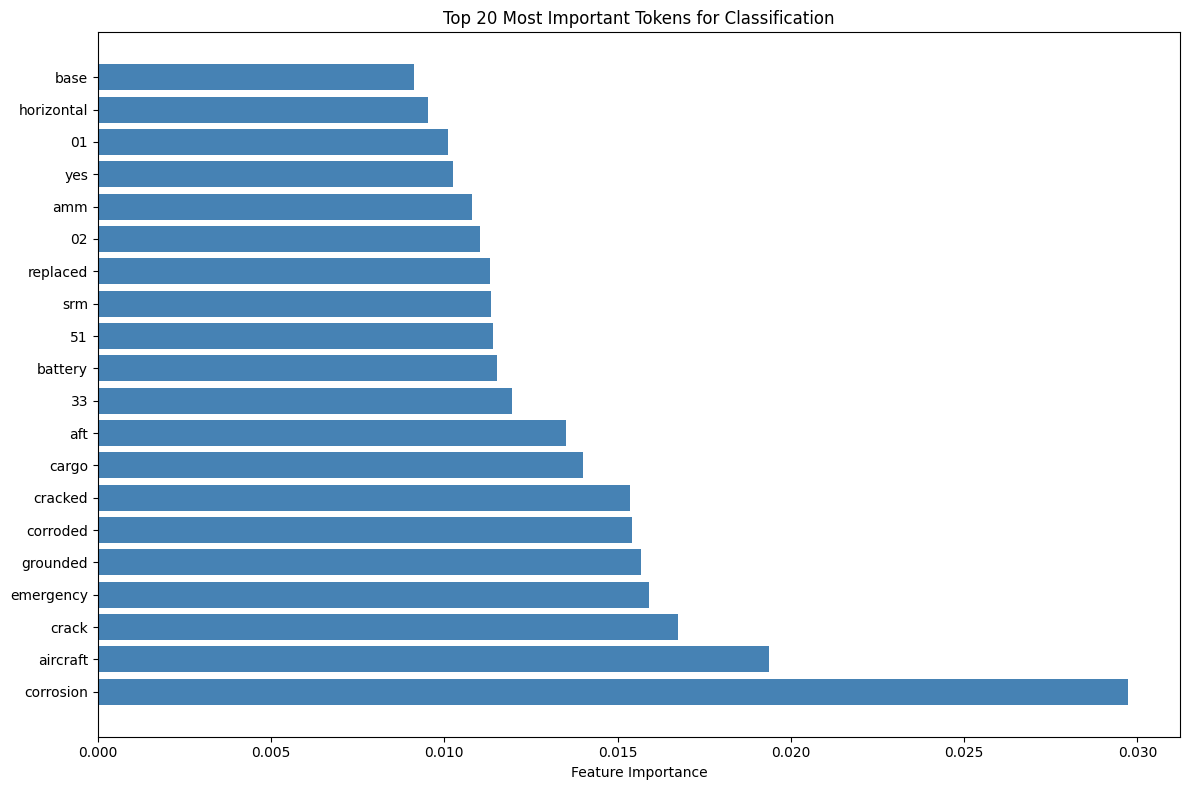

In [31]:
# Analyse most important tokens in TF-IDF model
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance = rf_tfidf.feature_importances_

# Get top 20 most important features
top_features_idx = np.argsort(feature_importance)[-20:]
top_features = [(feature_names[i], feature_importance[i]) for i in top_features_idx]
top_features.reverse()    # Highest importance first

print("Top 20 Most Important Tokens (TF-IDF Model):")
for token, importance in top_features:
    print(f"{token:15} : {importance:.4f}")

# Visualise
plt.figure(figsize=(12, 8))
tokens, importances = zip(*top_features)
plt.barh(range(len(tokens)), importances, color='steelblue')
plt.yticks(range(len(tokens)), tokens)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Tokens for Classification')
plt.tight_layout()
plt.show()

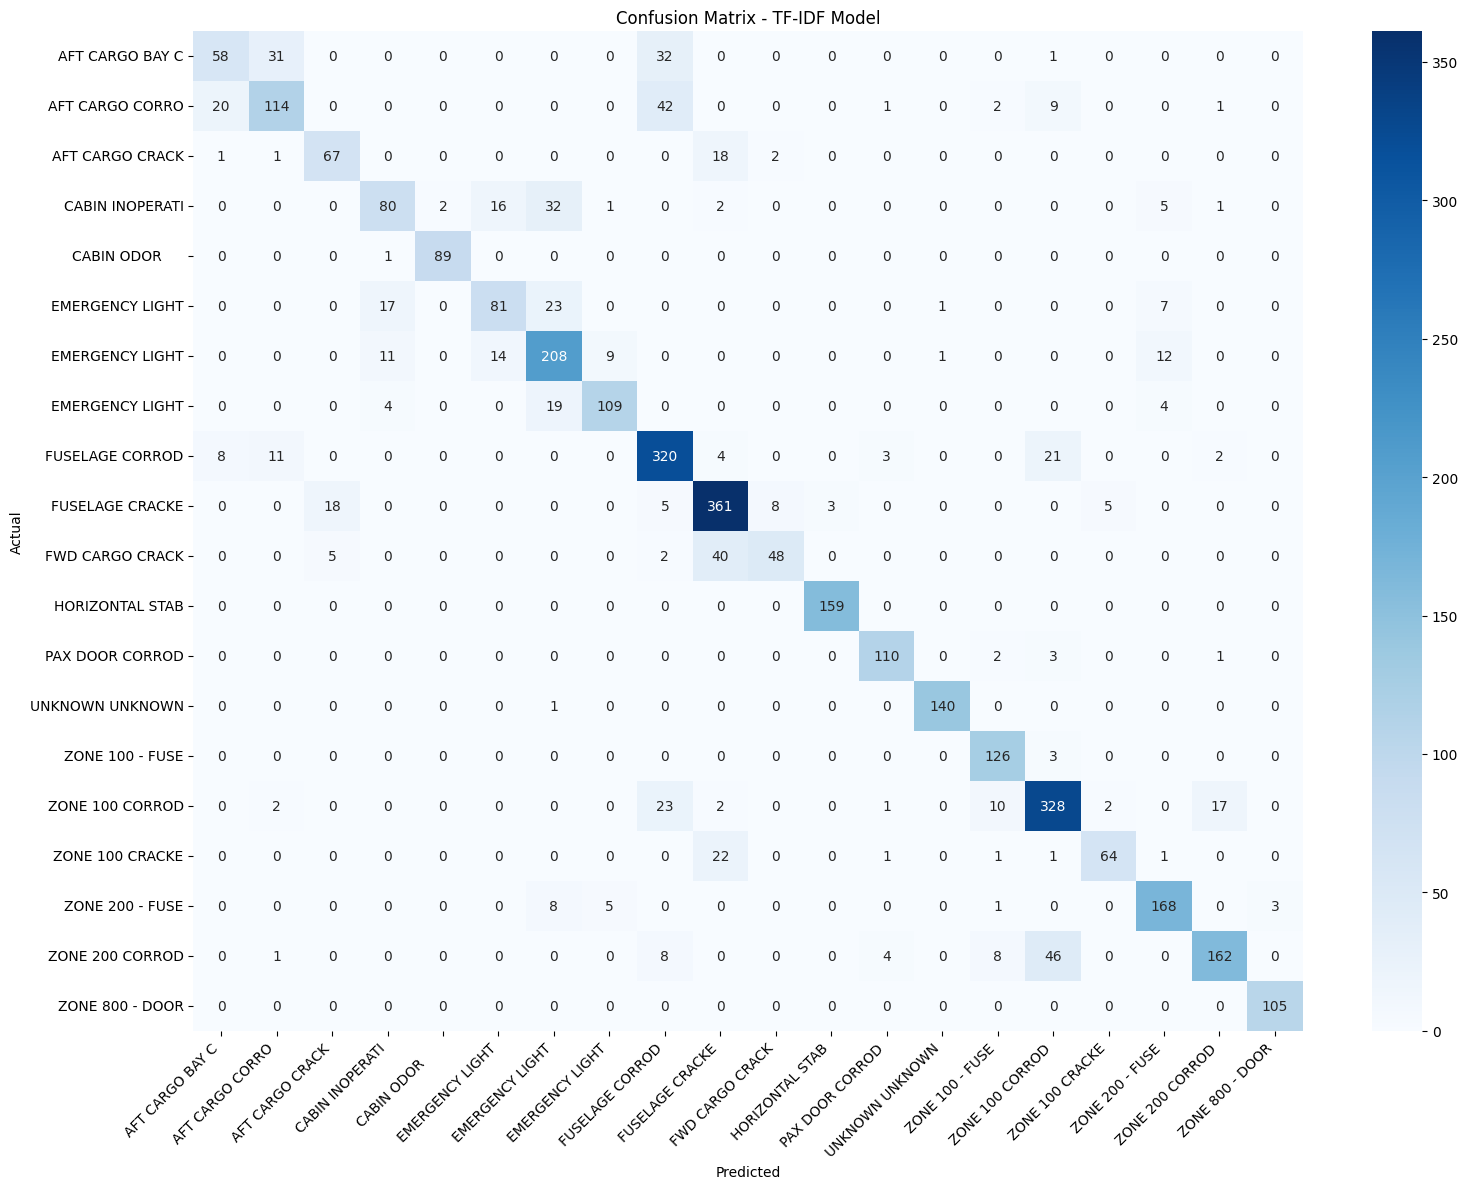


Most Problematic Classification Confusions:
True Category -> Predicted As | Count | Rate
FWD CARGO CRACKED    -> FUSELAGE CRACKED     |  40 | 42.1%
AFT CARGO BAY CORROD -> FUSELAGE CORRODED    |  32 | 26.2%
AFT CARGO BAY CORROD -> AFT CARGO CORRODED   |  31 | 25.4%
ZONE 100 CRACKED     -> FUSELAGE CRACKED     |  22 | 24.4%
CABIN INOPERATIVE    -> EMERGENCY LIGHTS INO |  32 | 23.0%
AFT CARGO CORRODED   -> FUSELAGE CORRODED    |  42 | 22.2%
AFT CARGO CRACKED    -> FUSELAGE CRACKED     |  18 | 20.2%
ZONE 200 CORRODED    -> ZONE 100 CORRODED    |  46 | 20.1%
EMERGENCY LIGHT INOP -> EMERGENCY LIGHTS INO |  23 | 17.8%
EMERGENCY LIGHTS NO  -> EMERGENCY LIGHTS INO |  19 | 14.0%


In [34]:
# Analyze confusion patterns for TF-IDF model:
conf_matrix = confusion_matrix(y_test, y_pred_tfidf)
labels = sorted(y_test.unique())

# Create confusion heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label[:15] for label in labels],
            yticklabels=[label[:15] for label in labels])
plt.title("Confusion Matrix - TF-IDF Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find most confused pairs
confused_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if (i != j) and (conf_matrix[i, j] > 2):    # At least 3 misclassifications
            confusion_rate = conf_matrix[i, j] / conf_matrix[i].sum()
            if confusion_rate > 0.1:    # More than 10% confusion
                confused_pairs.append((labels[i], labels[j], conf_matrix[i, j], confusion_rate))

confused_pairs.sort(key=lambda x: x[3], reverse=True)

print("\nMost Problematic Classification Confusions:")
print("True Category -> Predicted As | Count | Rate")
print("="*60)
for true_cat, pred_cat, count, rate in confused_pairs[:10]:
    print(f"{true_cat[:20]:<20} -> {pred_cat[:20]:<20} | {count:>3} | {rate:.1%}")

## 4. Model Selection Justication

Based on the analysis performed, we can now justify our model selection decision

In [35]:
# Calculate business impact metrics
# Get detailed classification report as dict
tfidf_report = classification_report(y_test, y_pred_tfidf, output_dict=True)

# ID low performing categories
low_performance = []
for category, metrics in tfidf_report.items():
    if category not in ['accuracy', 'macro avg', 'weighted avg']:
        if metrics['f1-score'] < 0.7:    # Threshold for problematic categories; can adjust
            low_performance.append((category, metrics['f1-score'], metrics['support']))

low_performance.sort(key=lambda x: x[1])    # Sort by F1 Score

print("Categories Requiring Immediate Attention (F1 < 0.7):")
print("Category | F1 Score | Test Samples")
print("="*60)
for category, f1, support in low_performance:
    print(f"{category[:30]:<30} | {f1:.3f} | {int(support)}")

# Calculate total incidents affected
total_affected = sum([support for _, _, support in low_performance])
total_incidents = len(y_test)
affected_percentage = (total_affected / total_incidents) * 100

print(f"\nBusiness Impact Summary:")
print(f"- {len(low_performance)} categories need immediate attention")
print(f"- {total_affected:.0f} out of {total_incidents} test incidents affected ({affected_percentage:.1f}%)")
print(f"- Focusing on these categories could improve {affected_percentage:.1f}% of classifications")

Categories Requiring Immediate Attention (F1 < 0.7):
Category | F1 Score | Test Samples
AFT CARGO BAY CORRODED         | 0.555 | 122
FWD CARGO CRACKED              | 0.627 | 95
CABIN INOPERATIVE              | 0.635 | 139
AFT CARGO CORRODED             | 0.653 | 189
EMERGENCY LIGHT INOPERATIVE    | 0.675 | 129

Business Impact Summary:
- 5 categories need immediate attention
- 674 out of 3552 test incidents affected (19.0%)
- Focusing on these categories could improve 19.0% of classifications


## 5. Methodology Rationale

### 5.1 Experimental Design Decisions

Our model comparison followed a systematic approach to ensure valid conclusions for business applications.